In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
path = 'C:\\Users\\User\\Downloads\\archive\\dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [3]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path     Labels
0  C:\Users\User\Downloads\archive\dataset\rime\5...       rime
1  C:\Users\User\Downloads\archive\dataset\rime\5...       rime
2  C:\Users\User\Downloads\archive\dataset\rime\5...       rime
3  C:\Users\User\Downloads\archive\dataset\sandst...  sandstorm
4  C:\Users\User\Downloads\archive\dataset\sandst...  sandstorm

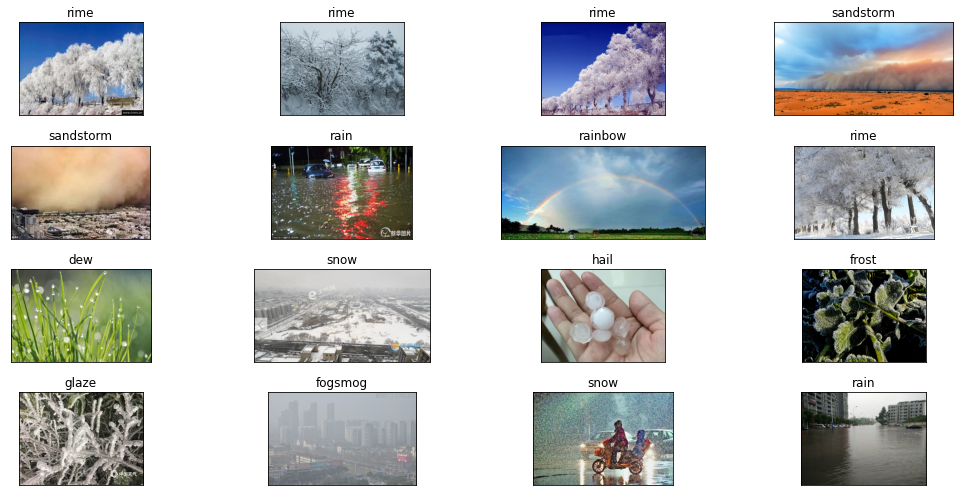

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

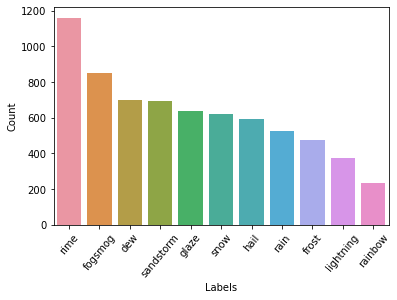

In [5]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [9]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# EfficientNetB7

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 203s 4s/step
              precision    recall  f1-score   support

         dew       0.83      0.93      0.87       153
     fogsmog       0.88      0.70      0.78       168
       frost       0.65      0.57      0.61       108
       glaze       0.73      0.74      0.74       126
        hail       0.87      0.78      0.83       106
   lightning       0.94      0.83      0.88        72
        rain       0.67      0.88      0.76        94
     rainbow       0.90      0.95      0.93        60
        rime       0.86      0.84      0.85       223
   sandstorm       0.76      0.90      0.82       155
        snow       0.73      0.66      0.69       108

    accuracy                           0.80      1373
   macro avg       0.80      0.80      0.80      1373
we

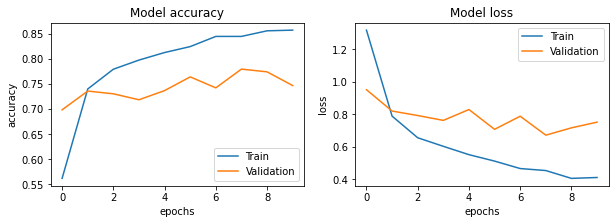

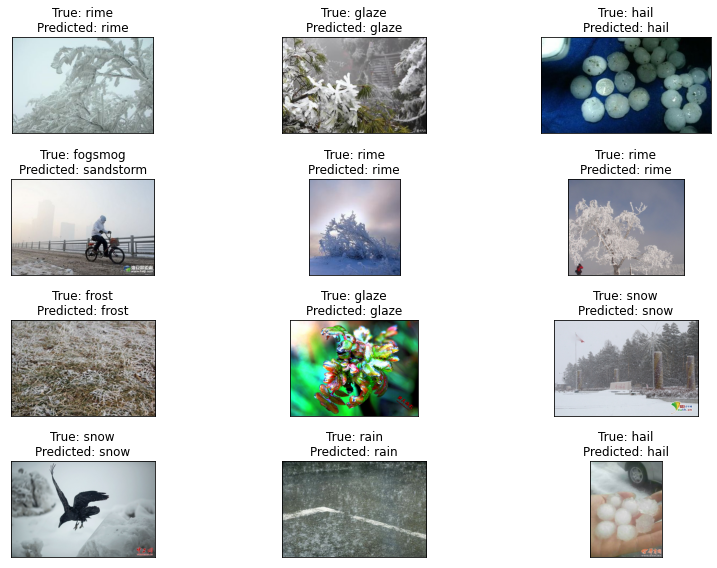

    Test Loss: 0.63607
Test Accuracy: 79.83%


In [11]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)

result_ENet = result_test(test_gen_ENet,ENet_model)

# ResNet

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 60s 1s/step
              precision    recall  f1-score   support

         dew       0.95      0.87      0.91       153
     fogsmog       0.87      0.89      0.88       168
       frost       0.68      0.68      0.68       108
       glaze       0.70      0.68      0.69       126
        hail       0.85      0.87      0.86       106
   lightning       0.93      0.97      0.95        72
        rain       0.73      0.86      0.79        94
     rainbow       1.00      0.97      0.98        60
        rime       0.88      0.85      0.86       223
   sandstorm       0.92      0.90      0.91       155
        snow       0.72      0.74      0.73       108

    accuracy                           0.84      1373
   macro avg       0.84      0.84      0.84      1373
wei

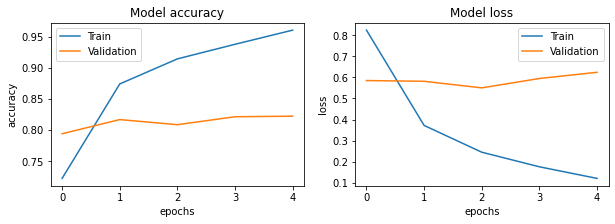

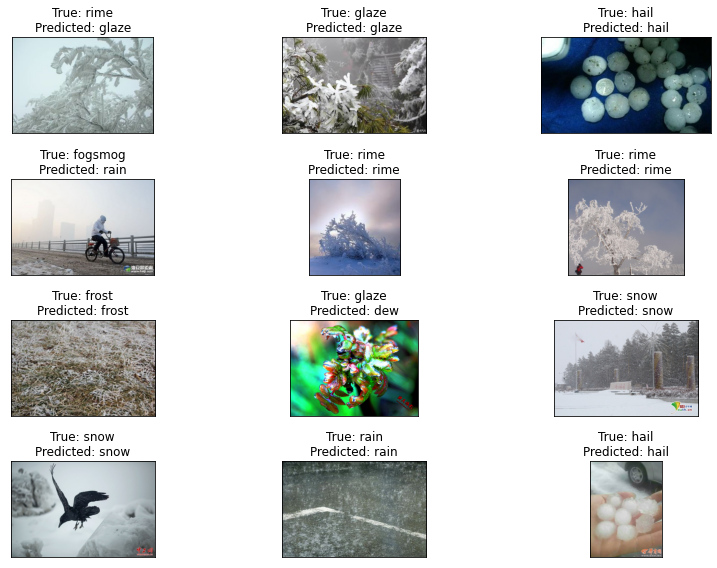

    Test Loss: 0.58950
Test Accuracy: 83.83%


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model, callback=func(ResNet50)
history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ResNet= plot(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = result_test(test_gen_ResNet,ResNet_model)

# MobileNet

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 30s 618ms/step
              precision    recall  f1-score   support

         dew       0.87      0.88      0.87       153
     fogsmog       0.76      0.92      0.83       168
       frost       0.78      0.50      0.61       108
       glaze       0.58      0.71      0.64       126
        hail       0.85      0.89      0.87       106
   lightning       0.93      0.97      0.95        72
        rain       0.93      0.69      0.79        94
     rainbow       0.95      0.97      0.96        60
        rime       0.84      0.83      0.83       223
   sandstorm       0.95      0.81      0.87       155
        snow       0.62      0.70      0.66       108

    accuracy                           0.80      1373
   macro avg       0.82      0.81      0.81      1373


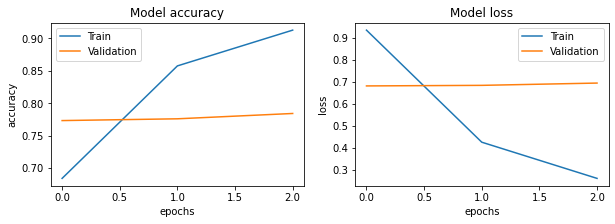

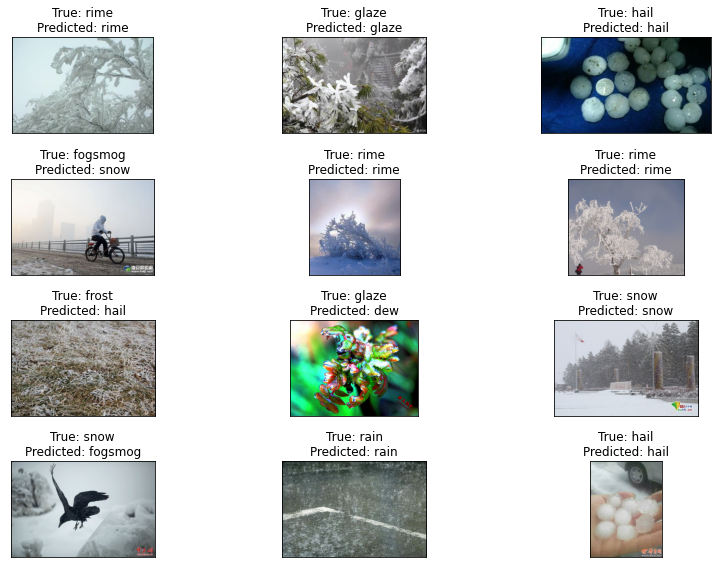

    Test Loss: 0.63227
Test Accuracy: 80.48%


In [13]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

# VGG19

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 144s 3s/step
              precision    recall  f1-score   support

         dew       0.85      0.92      0.89       153
     fogsmog       0.85      0.84      0.84       168
       frost       0.72      0.49      0.58       108
       glaze       0.59      0.71      0.65       126
        hail       0.81      0.81      0.81       106
   lightning       0.86      0.94      0.90        72
        rain       0.84      0.77      0.80        94
     rainbow       0.90      0.92      0.91        60
        rime       0.79      0.83      0.81       223
   sandstorm       0.87      0.88      0.87       155
        snow       0.69      0.60      0.64       108

    accuracy                           0.80      1373
   macro avg       0.80      0.79      0.79      1373
we

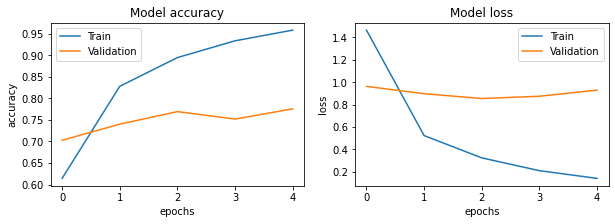

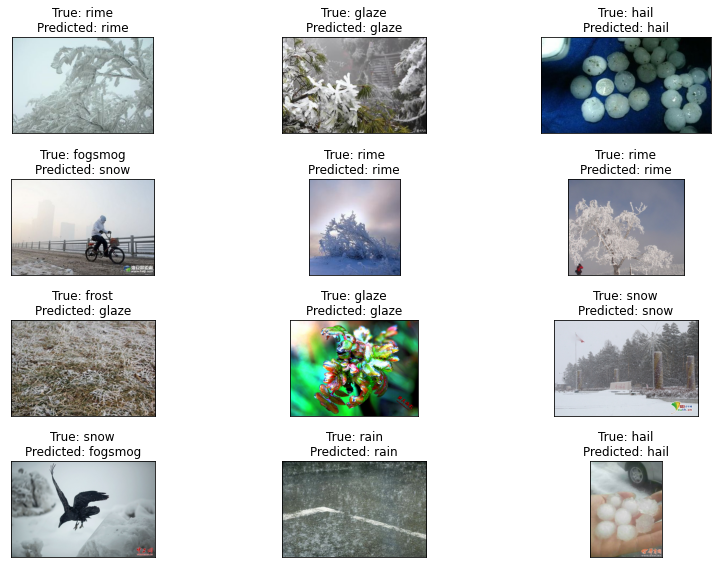

    Test Loss: 0.80991
Test Accuracy: 79.61%


In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = gen(VGG19_pre,train_df,test_df)
VGG19_model, callback=func(VGG19)
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

# Xception

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 58s 1s/step
              precision    recall  f1-score   support

         dew       0.90      0.91      0.90       153
     fogsmog       0.86      0.69      0.77       168
       frost       0.77      0.63      0.69       108
       glaze       0.69      0.61      0.65       126
        hail       0.82      0.84      0.83       106
   lightning       0.89      0.89      0.89        72
        rain       0.92      0.51      0.66        94
     rainbow       0.90      0.92      0.91        60
        rime       0.75      0.83      0.79       223
   sandstorm       0.77      0.88      0.83       155
        snow       0.50      0.78      0.61       108

    accuracy                           0.77      1373
   macro avg       0.80      0.77      0.77      1373
wei

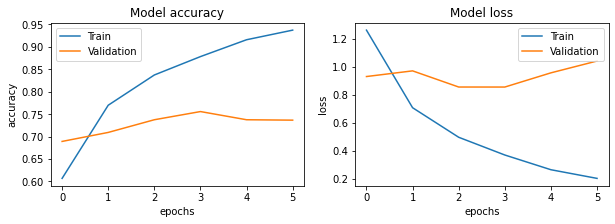

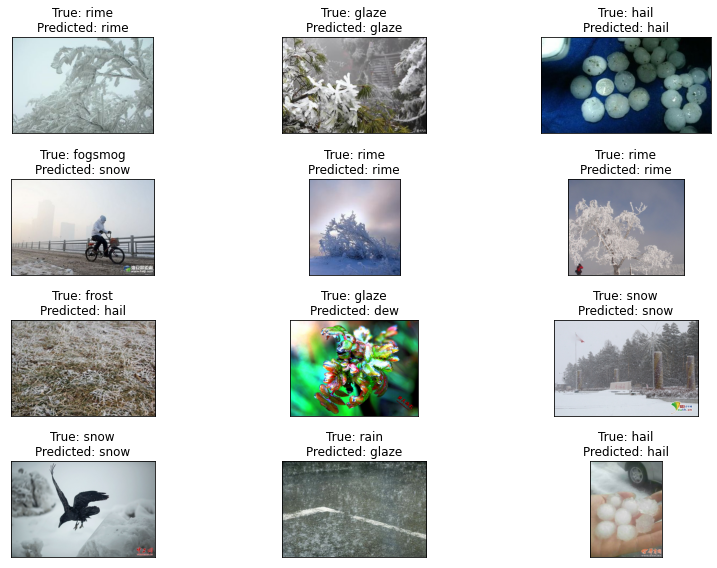

    Test Loss: 0.91128
Test Accuracy: 77.28%


In [15]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)
Xception_model, callback=func(Xception)
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_Xception = plot(history,test_gen_Xception,train_gen_Xception, Xception_model)
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)

# InceptionResNetV2

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 68s 1s/step
              precision    recall  f1-score   support

         dew       0.77      0.80      0.79       153
     fogsmog       0.76      0.77      0.76       168
       frost       0.64      0.58      0.61       108
       glaze       0.69      0.48      0.57       126
        hail       0.75      0.75      0.75       106
   lightning       0.87      0.92      0.89        72
        rain       0.79      0.51      0.62        94
     rainbow       0.93      0.90      0.92        60
        rime       0.79      0.70      0.74       223
   sandstorm       0.75      0.87      0.81       155
        snow       0.42      0.69      0.53       108

    accuracy                           0.72      1373
   macro avg       0.74      0.73      0.73      1373
wei

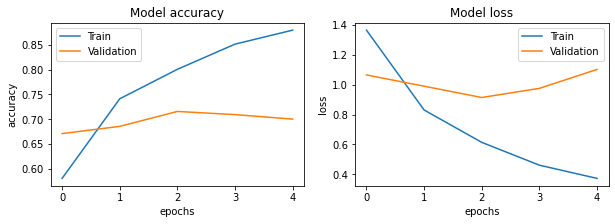

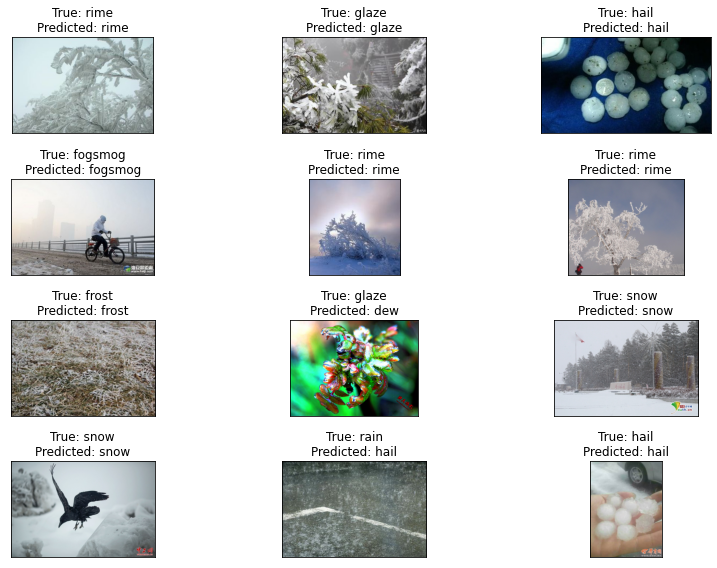

    Test Loss: 1.06183
Test Accuracy: 72.18%


In [17]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
IRNV2_pre=preprocess_input
train_gen_IRNV2, valid_gen_IRNV2, test_gen_IRNV2 = gen(IRNV2_pre,train_df,test_df)
IRNV2_model, callback=func(InceptionResNetV2)
history = IRNV2_model.fit(
    train_gen_IRNV2,
    validation_data=valid_gen_IRNV2,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_IRNV2 =plot(history,test_gen_IRNV2,train_gen_IRNV2, IRNV2_model)
result_IRNV2 = result_tresult_IRNV2 = result_test(test_gen_IRNV2,IRNV2_model)

# VGG16

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 107s 2s/step
              precision    recall  f1-score   support

         dew       0.85      0.90      0.87       153
     fogsmog       0.86      0.77      0.81       168
       frost       0.64      0.63      0.64       108
       glaze       0.66      0.58      0.62       126
        hail       0.85      0.89      0.87       106
   lightning       0.94      0.83      0.88        72
        rain       0.84      0.81      0.83        94
     rainbow       0.82      0.92      0.87        60
        rime       0.81      0.78      0.79       223
   sandstorm       0.84      0.92      0.88       155
        snow       0.57      0.68      0.62       108

    accuracy                           0.79      1373
   macro avg       0.79      0.79      0.79      1373
we

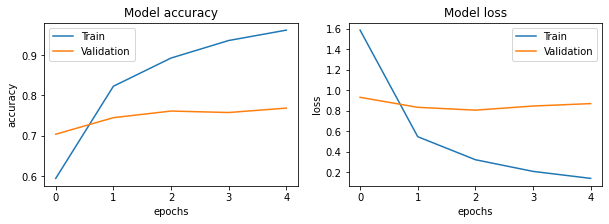

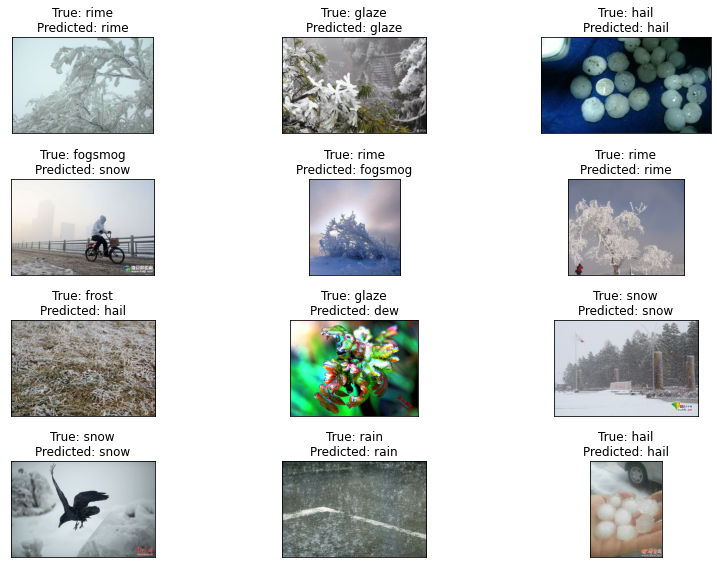

    Test Loss: 0.82390
Test Accuracy: 78.81%


In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)
model_VGG16, callback=func(VGG16)
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

# ResNet101

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 110s 2s/step
              precision    recall  f1-score   support

         dew       0.93      0.93      0.93       153
     fogsmog       0.89      0.92      0.90       168
       frost       0.67      0.74      0.70       108
       glaze       0.72      0.73      0.73       126
        hail       0.88      0.93      0.91       106
   lightning       0.91      0.96      0.93        72
        rain       0.91      0.79      0.85        94
     rainbow       0.98      0.93      0.96        60
        rime       0.92      0.84      0.88       223
   sandstorm       0.93      0.90      0.92       155
        snow       0.69      0.78      0.73       108

    accuracy                           0.86      1373
   macro avg       0.86      0.86      0.86      1373
we

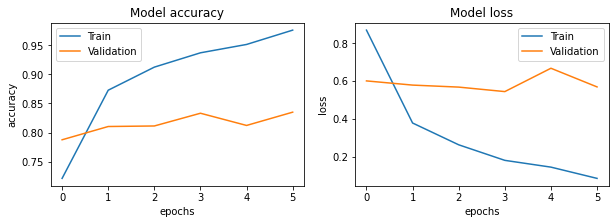

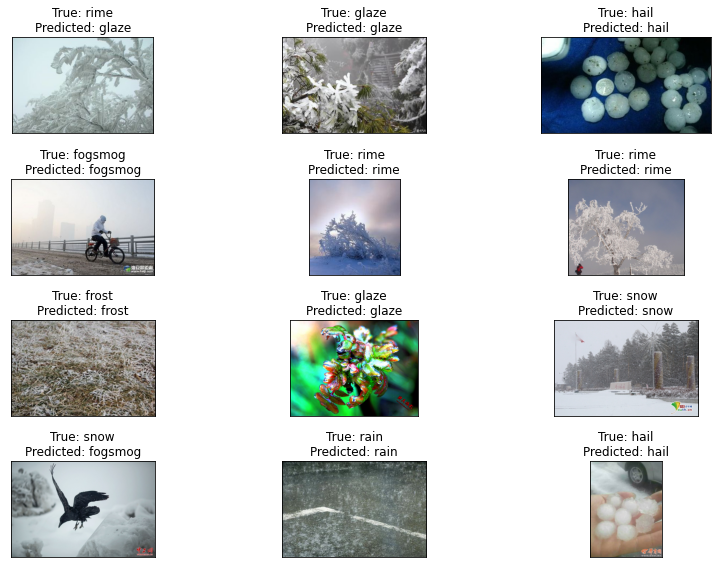

    Test Loss: 0.56079
Test Accuracy: 85.80%


In [19]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

ResNet101_pre=preprocess_input
train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = gen(ResNet101_pre,train_df,test_df)
model_ResNet101, callback=func(ResNet101)
history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)
result_ResNet101 = result_test(test_gen_ResNet101,model_ResNet101)

# DenseNet201

In [25]:
output = pd.DataFrame({'Model':['EfficientNetB7','ResNet50','MobileNet','VGG19','Xception','InceptionResNetV2',
                               'VGG16','ResNet101'],
                      'Accuracy':[result_ENet[1], result_ResNet[1], result_MobileNet[1], result_VGG19[1],
                                  result_Xception[1],result_IRNV2[1],result_VGG16[1],result_ResNet101[1]
                                 ]})

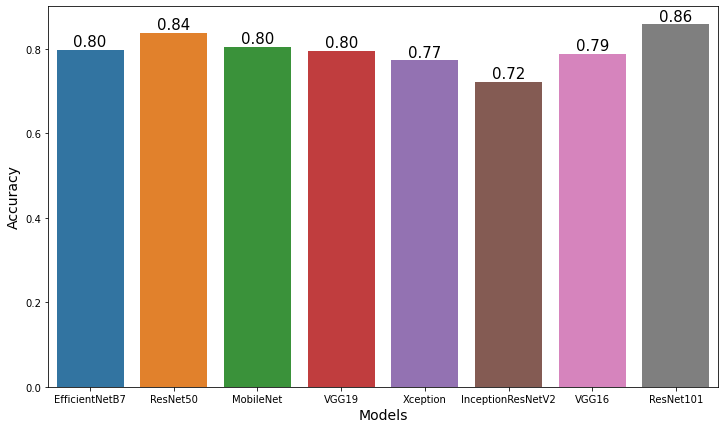

In [26]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()